In [1]:
from astropy.table import Table, vstack, Column
from tqdm import tqdm
from astropy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import astropy.units as u
import seaborn as sns
from scipy.stats import ks_2samp
from matplotlib.lines import Line2D
import warnings

In [2]:
control_sample = Table.read('K_corrected_control_sample_mag_errors.csv', format='ascii')

control_sample['FUV_ext_cor'] = control_sample['FUV']-control_sample['ebv_1']*8.24
control_sample['NUV_ext_cor'] = control_sample['NUV']-control_sample['ebv_1']*8.2

control_sample['FUV-NUV'] = control_sample['FUV_ext_cor']-control_sample['NUV_ext_cor']

control_sample_blue = control_sample[(control_sample['FUV-NUV'] >= -1.5) & (control_sample['FUV-NUV'] <= 2.75)]
control_sample_blue = control_sample_blue[control_sample_blue['FUV']<30]

In [3]:
len(control_sample_blue)

781

In [4]:
def calcular_sfr_new(archivo):
    H_0 = 67.4  # km/s/Mpc
    c = 300000  # km/s
    L_sun = 3.83 * 10**33
    L_sun_nuv = 7.69 * 10**31
    L_sun_fuv = 1.92 * 10**30
    eta_fuv = 1.98e+15
    eta_nuv = 1.32e+15
    eta_w4 = 1.25e+13

    # Distancia en Mpc
    archivo['Distance (Mpc)'] = (archivo['z'] * c) / H_0

    # Magnitudes absolutas
    archivo['M_FUV'] = archivo['FUV_corrected'] - 5 * np.log10(archivo['Distance (Mpc)'] * 1e6) + 5
    archivo['M_NUV'] = archivo['NUV_corrected'] - 5 * np.log10(archivo['Distance (Mpc)'] * 1e6) + 5
    archivo['M_i'] = archivo['m_i_corrected'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5 + 1.592*archivo['ebv']
    # Reemplazar valores no numéricos en 'mag_w4' por np.nan
    def convertir_a_float(valor):
        try:
            return float(valor)
        except (ValueError, TypeError):
            return np.nan

    archivo['mag_w4'] = [convertir_a_float(x) for x in archivo['mag_w4']]

    # Flujos
    archivo['F_FUV'] = 10 ** (-(archivo['FUV_corrected'] + 48.6) / 2.5) * eta_fuv
    archivo['F_NUV'] = 10 ** (-(archivo['NUV_corrected'] + 48.6) / 2.5) * eta_nuv
    archivo['F_w4'] = np.where(np.isnan(archivo['mag_w4']), np.nan, 10 ** (-(archivo['mag_w4'] + 48.6) / 2.5) * eta_w4)

    # Luminosidades
    archivo['L_FUV'] = 4 * np.pi * ((archivo['Distance (Mpc)'] * 3.086e+24) ** 2) * archivo['F_FUV']
    archivo['L_NUV'] = 4 * np.pi * ((archivo['Distance (Mpc)'] * 3.086e+24) ** 2) * archivo['F_NUV']
    archivo['L_w4'] = 4 * np.pi * ((archivo['Distance (Mpc)'] * 3.086e+24) ** 2) * archivo['F_w4']

    # SFR calculada condicionalmente
    SFR_NUV = []
    SFR_FUV = []

    for i in range(len(archivo)):
        #Calculando el flujo corregido por polvo
        F_FUV = 10**(-(archivo['FUV_corrected'][i] - 1.24 + 48.6)/2.5)*eta_fuv
        F_NUV = 10**(-(archivo['NUV_corrected'][i] - 1.07 + 48.6)/2.5)*eta_nuv
        
        if not np.isnan(archivo['mag_w4'][i]):
            # Método estándar (con W4)
            L_FUV_cor = (archivo['L_FUV'][i] + 3.89 * archivo['L_w4'][i]) / L_sun
            L_NUV_cor = (archivo['L_NUV'][i] + 2.26 * archivo['L_w4'][i]) / L_sun

            sfr_FUV = np.log10(L_FUV_cor) - 9.51
            sfr_NUV = np.log10(L_NUV_cor) - 9.33
        else:
            L_NUV_cor_abs = F_NUV*4*np.pi*((archivo['Distance (Mpc)'][i]*3.086*10**24)**2)/L_sun
            L_FUV_cor_abs = F_FUV*4*np.pi*((archivo['Distance (Mpc)'][i]*3.086*10**24)**2)/L_sun

            sfr_FUV = np.log10(L_FUV_cor_abs) - 9.51
            sfr_NUV = np.log10(L_NUV_cor_abs) - 9.33

        SFR_NUV.append(sfr_NUV)
        SFR_FUV.append(sfr_FUV)

    # Añadir SFR al archivo
    archivo['logSFR_NUV'] = SFR_NUV
    archivo['logSFR_FUV'] = SFR_FUV

    print(f"Mediana logSFR_NUV: {np.nanmedian(SFR_NUV)}, logSFR_FUV: {np.nanmedian(SFR_FUV)}")

    return archivo

In [5]:
sfr_cs_blue = calcular_sfr_new(control_sample_blue)
sfr_cs_blue

Mediana logSFR_NUV: 0.21239428122246018, logSFR_FUV: 0.17110499707413673


/tmp/ipykernel_8571/1180814179.py:21: UserWarning: Warning: converting a masked element to nan.
  return float(valor)


Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,z,stellar_mass,error_stellar_mass,log_SFR,error_log_SFR,index,survey,band,FUV,fuv_magerr,NUV,nuv_magerr,ebv_1,m_i_corrected,m_g_corrected,m_r_corrected,m_z_corrected,FUV_corrected,NUV_corrected,e_mag_g,e_mag_r,e_mag_i,e_mag_z,FUV_ext_cor,NUV_ext_cor,FUV-NUV,Distance (Mpc),M_FUV,M_NUV,M_i,F_FUV,F_NUV,F_w4,L_FUV,L_NUV,L_w4,logSFR_NUV,logSFR_FUV
int64,int64,int64,float64,float64,str3,float64,str10,float64,str10,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,str10,float64,str10,float64,float64,float64,str9,str8,float64,float64,str8,str8,float64,float64,str10,float64,str10,float64,float64,float64,str9,str12,float64,float64,str8,str8,float64,float64,str10,float64,str10,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,int64,str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,2,4345,146.037899914,5.936883936,SER,0.518974579120454,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[573.0000],0.0,[573.0000],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365471,--,4345,0.03810383,90.73341,135.2012,164.73248,175.39871,1.6321088,1.1554528,1.3240439,1.287701,0.95234656,52959.43,7.7095037,7430.0376,0.034991268,353575.5,-0.09275164,544142.7,17.605581,17.172548,16.958052,16.889935,17.767561,18.341188,--,nan,0.433033,0.21449661,0.28261375,0.06811714,0.0101,8.07,0.053,-1.813,0.062,1,AIS,3,19.8634,0.1513609,19.63169,0.08597316,0.0373673,16.958762436073716,17.609828071378214,17.184430474143486,16.892502838445232,19.8554745305942,19.636655586727446,0.0027877545974981407,0.003718943566049242,0.004585566655560133,0.006143524680625916,19.555493448,19.325278139999998,0.23021530800000178,44.95548961424332,-13.408439129240726,-13.62725807310748,-16.24448992640121,8.212499914073313e-13,6.697484181112596e-13,nan,1.9862895119431948e+41,1.6198651719377844e+41,nan,-1.2757199060434257,-1.299156224534448
5,5,3209,125.743385329,24.864193396,SER,0.396124539832107,344.9315,0.0208,343.3506,0.0049,36.8885,0.0559,17.1433,0.0013,0.9171,0.0023,0.1976,0.0002,78.5132,0.0177,344.9315,0.0208,343.3506,0.0049,35.983,0.0413,16.6977,0.0013,0.9759,0.0015,0.1976,0.0002,78.5132,0.0177,344.9315,0.0208,343.3506,0.0049,35.1191,0.0629,16.5306,0.0018,1.032,0.0026,0.1976,0.0002,78.5132,0.0177,344.9315,0.0208,343.3506,0.0049,34.184,0.1018,16.4441,0.0029,1.0927,0.0044,0.1976,0.0002,78.5132,0.0177,469217,--,3209,0.030500926,85.3396,93.5364,84.89223,89.02641,1.3353922,1.3477556,1.5884084,1.2457496,2.7116916,5983.596,2.1508393,65549.08,-0.1994719,435528.28,0.2200716,484509.88,17.672123,17.572548,17.67783,17.626204,18.362085,18.87445,--,14.922511,0.09957504,-0.10528183,-0.053655624,0.051626205,0.0182,7.745,0.126,-0.657,0.046,3,AIS,3,18.66118,0.09335154,18.67235,0.06822496,0.03053586,17

In [6]:
sfr_decals = Table.read('sfr_decals_k_corrected.csv', format='ascii')
print(len(sfr_decals))
sfr_decals.rename_column('zmemb', 'z')
sfr_decals = sfr_decals[sfr_decals['n_i'] != 0.0]
H_0 = 67.4 #km/s/Mpc
c = 300000

sfr_decals['Distance (Mpc)'] = (sfr_decals['z']*c)/H_0
sfr_decals['M_i'] = sfr_decals['m_i_corrected'] - 5*np.log10(sfr_decals['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_decals['ebv']
sfr_decals['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_decals['m_g_corrected'] - sfr_decals['m_i_corrected']) - 0.4*sfr_decals['M_i'])

mask = ~np.isnan(sfr_decals['stellar_mass_phot_i'])
sfr_decals = sfr_decals[mask]
len(sfr_decals)

559


378

In [7]:
H_0 = 67.4 #km/s/Mpc
c = 300000

sfr_cs_blue['Distance (Mpc)'] = (sfr_cs_blue['z']*c)/H_0
sfr_cs_blue['M_i'] = sfr_cs_blue['m_i_corrected'] - 5*np.log10(sfr_cs_blue['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_cs_blue['ebv_1']
sfr_cs_blue['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_cs_blue['m_g_corrected'] - sfr_cs_blue['m_i_corrected']) - 0.4*sfr_cs_blue['M_i'])

<>:44: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:44: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_8571/746558432.py:44: SyntaxWarning: invalid escape sequence '\o'
  plt.axvline(median_x, color='indigo', linestyle='--', linewidth=2, label=f'Median log $M_*$ = {median_x:.2f} $M_\odot$')
/tmp/ipykernel_8571/746558432.py:48: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('log $M_* [M_\odot]$', size=15)


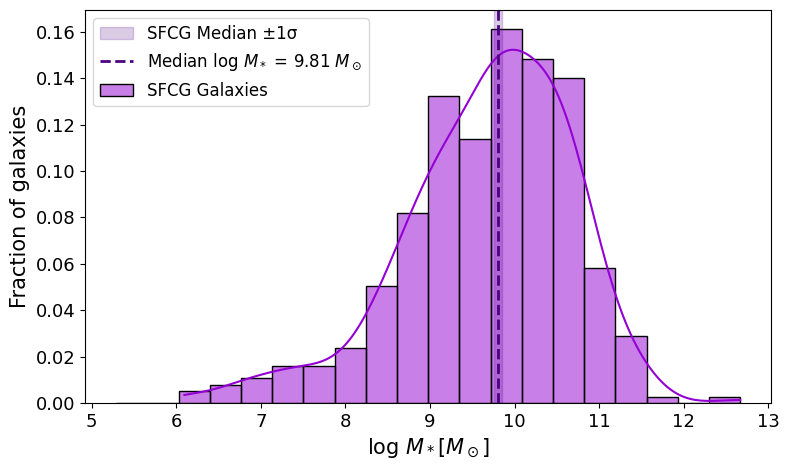

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Datos y limpieza
decals_mass = sfr_decals['stellar_mass_phot_i']
cs_mass = sfr_cs_blue['stellar_mass_phot_i']
decals_clean = decals_mass[~np.isnan(decals_mass)]
cs_clean = cs_mass[~np.isnan(cs_mass)]

# Bins para los histogramas
bin_edges = np.linspace(min(decals_clean.min(), cs_clean.min()), 
                        max(decals_clean.max(), cs_clean.max()), 
                        21)

# Función de bootstrap para la mediana
def bootstrap_median_ci(data, n_bootstrap=1000, ci=68):
    medians = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        medians.append(np.median(sample))
    lower = np.percentile(medians, 50 - ci/2)
    upper = np.percentile(medians, 50 + ci/2)
    return lower, upper

# Medianas y bandas de incertidumbre
median_x = np.median(decals_clean)
median_y = np.median(cs_clean)
low_x, high_x = bootstrap_median_ci(decals_clean)
low_y, high_y = bootstrap_median_ci(cs_clean)

# === Graficar ===
plt.figure(figsize=(8, 4.8))
sns.histplot(decals_clean, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCG Galaxies')
#sns.histplot(cs_clean, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field Galaxies')

# Regiones sombreadas ±1σ
plt.axvspan(low_x, high_x, color='indigo', alpha=0.2, label='SFCG Median ±1σ')
#plt.axvspan(low_y, high_y, color='teal', alpha=0.2, label='Field Median ±1σ')

# Líneas de la mediana
plt.axvline(median_x, color='indigo', linestyle='--', linewidth=2, label=f'Median log $M_*$ = {median_x:.2f} $M_\odot$')
#plt.axvline(median_y, color='teal', linestyle='--', linewidth=2)

# Etiquetas y título
plt.xlabel('log $M_* [M_\odot]$', size=15)
plt.ylabel('Fraction of galaxies', size=15)
#plt.title('Mass of the SFCG and Field Galaxies color filtered', size=16)
plt.xticks(size=13)
plt.yticks(size=13)

# KS-test
#ks_stat, p_value = ks_2samp(decals_clean, cs_clean)
#plt.text(6.7, 0.12, f'KS-test = {ks_stat:.2f}', color='black', fontsize=12)
#plt.text(6.7, 0.11, f'p-value = {p_value:.2f}', color='black', fontsize=12)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_8571/1583975566.py:48: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('log $SFR [M_\odot/yr]$', size=14)


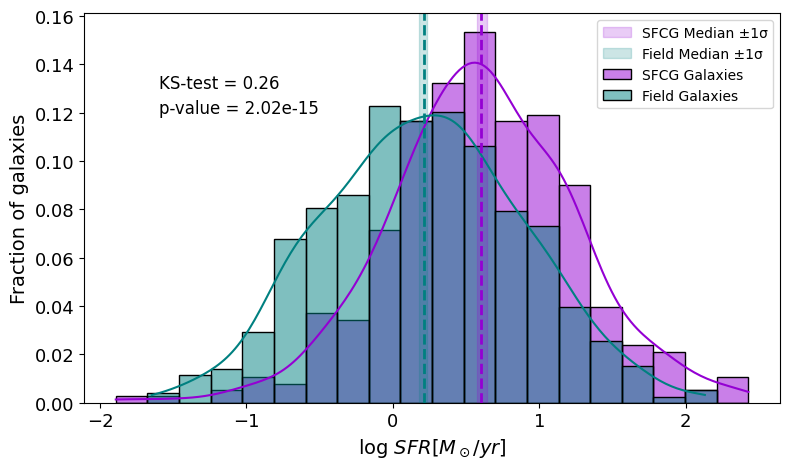

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Datos y limpieza
decals_sfr = sfr_decals['logSFR_NUV']
cs_sfr = sfr_cs_blue['logSFR_NUV']
decals_clean = decals_sfr[~np.isnan(decals_sfr)]
cs_clean = cs_sfr[~np.isnan(cs_sfr)]

# Bins para los histogramas
bin_edges = np.linspace(min(decals_clean.min(), cs_clean.min()), 
                        max(decals_clean.max(), cs_clean.max()), 
                        21)

# Función para estimar incertidumbre de la mediana por bootstrap
def bootstrap_median_ci(data, n_bootstrap=1000, ci=68):
    medians = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        medians.append(np.median(sample))
    lower = np.percentile(medians, 50 - ci/2)
    upper = np.percentile(medians, 50 + ci/2)
    return lower, upper

# Calcular mediana y bandas de incertidumbre (68% intervalo de confianza)
median_x = np.median(decals_clean)
median_y = np.median(cs_clean)
low_x, high_x = bootstrap_median_ci(decals_clean)
low_y, high_y = bootstrap_median_ci(cs_clean)

# === Graficar ===
plt.figure(figsize=(8, 4.8))
sns.histplot(decals_clean, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCG Galaxies')
sns.histplot(cs_clean, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field Galaxies')

# Shaded vertical regions (mediana ± 1σ)
plt.axvspan(low_x, high_x, color='darkviolet', alpha=0.2, label='SFCG Median ±1σ')
plt.axvspan(low_y, high_y, color='teal', alpha=0.2, label='Field Median ±1σ')

# Líneas de la mediana
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=2)
plt.axvline(median_y, color='teal', linestyle='--', linewidth=2)

# Etiquetas
plt.xlabel('log $SFR [M_\odot/yr]$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
#plt.title('SFR of the SFCG and Field Galaxies color filtered', size=16)
plt.xticks(size=13)
plt.yticks(size=13)

# KS-test
ks_stat, p_value = ks_2samp(decals_clean, cs_clean)
plt.text(-1.6, 0.13, f'KS-test = {ks_stat:.2f}', color='black', fontsize=12)
plt.text(-1.6, 0.12, f'p-value = {p_value:.2e}', color='black', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()



In [12]:
sfr_decals['FUV-NUV'] = sfr_decals['FUV']-sfr_decals['NUV']

KeyError: 'FUV'

In [11]:
decals_color = sfr_decals['FUV-NUV']
cs_color = sfr_cs_blue['FUV-NUV']

bin_edges = np.linspace(min(decals_color.min(), cs_color.min()), 
                        max(decals_color.max(), cs_color.max()), 
                        30)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(8, 4.8))
sns.histplot(decals_color, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCG Galaxies')
sns.histplot(cs_color, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field Galaxies')

# Calcular medianas
median_x = np.nanmedian(decals_color)
median_y = np.nanmedian(cs_color)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label=f'Median FUV-NUV SFCGs')
plt.axvline(median_y, color='teal', linestyle='--', linewidth=3, label=f'Median FUV-NUV Field')

# Etiquetas y título
plt.xlabel('$FUV - NUV$', size=14)
plt.ylabel('Fraction of galaxies', size=14)
plt.title('FUV-NUV of the SFCG and Field Galaxies', size=16)
plt.xticks(size=13)
plt.yticks(size=13)

plt.legend()
print(median_x)
print(median_y)

decals_color = decals_color[~np.isnan(decals_color)]
cs_color = cs_color[~np.isnan(cs_color)]

# Realizar el KS test
ks_stat, p_value = ks_2samp(decals_color, cs_color)
print(ks_stat, p_value)

# Añadir texto al gráfico
#plt.text(7, 0.12, 'KS-test = 0.07', color='black', fontsize=12, verticalalignment='bottom')
#plt.text(7, 0.11, 'p-value = 0.21', color='black', fontsize=12, verticalalignment='bottom')

plt.show()

KeyError: 'FUV-NUV'

In [13]:
decals_raw_k_corrected = Table.read('K_corrected_decals_data_mag_errors.csv', format='ascii')
decals_k_corrected = decals_raw_k_corrected[decals_raw_k_corrected['type'] != 'PSF']

# Convertir la tabla de astropy a un DataFrame de pandas
df2 = decals_k_corrected.to_pandas()
# Reemplazar valores infinitos por NaN
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertir de nuevo el DataFrame a una tabla de astropy
decals_k_corrected = Table.from_pandas(df2)

df_cs = sfr_cs_blue.to_pandas()

cs_no_zero = df_cs[df_cs['n_r'] != 0.0]
g_r_cs = cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']
n_r_cs = cs_no_zero['n_r']

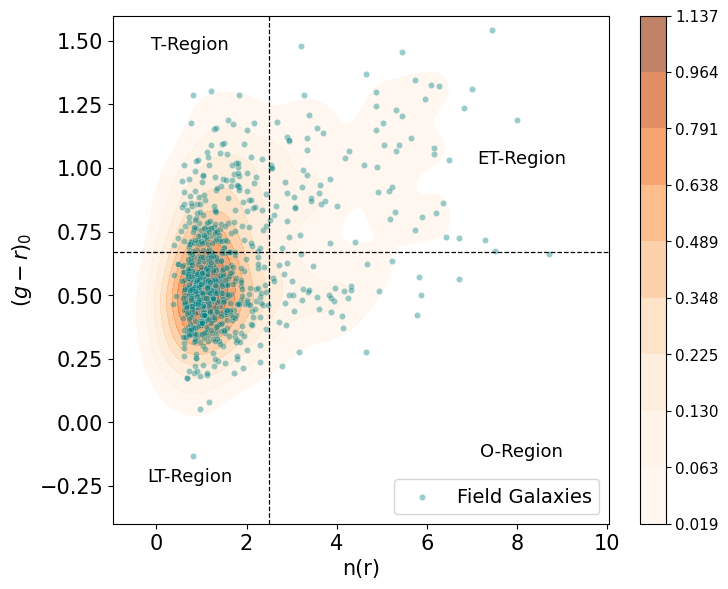

745
0.5611207990233886


In [14]:
median_error = np.mean(cs_no_zero['e_mag_g']+cs_no_zero['e_mag_r'])

plt.figure(figsize=(8, 6.6))

kde = sns.kdeplot(x=n_r_cs, y=g_r_cs, cmap='Oranges', alpha = 0.6, fill=True, cbar=True)

sns.scatterplot(data=cs_no_zero, x=cs_no_zero['n_r'], y=g_r_cs, color='teal', s=20, alpha=0.4, label='Field Galaxies')

#plt.errorbar(cs_no_zero['n_r'], g_r_cs, xerr= cs_no_zero['e_n_r'],
#             yerr=(cs_no_zero['e_mag_r']+cs_no_zero['e_mag_g']), fmt='None',
#             color='teal', lw=1, label='Error bars')

# Acceder al colorbar y cambiar el tamaño de los ticks
cbar = kde.figure.axes[-1]  # El colorbar es normalmente el último eje
cbar.tick_params(labelsize=11)

plt.ylim(-0.4, 1.6)
plt.xticks(size=15)
plt.yticks(size=15)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('$(g-r)_{0}$', size=15)

# Añadir una línea horizontal en y=50
plt.legend(loc='lower right', fontsize=14)
plt.axhline(y=0.67, color='black', linestyle='--', linewidth=0.9)

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=0.9)

# Agregar texto en coordenadas específicas
plt.text(0.75, 1.45, 'T-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8.1, 1, 'ET-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8.1, -0.15, 'O-Region', fontsize=13, ha='center', va='bottom', color='black')

plt.show()
print(len(cs_no_zero))
print(np.median(g_r_cs))

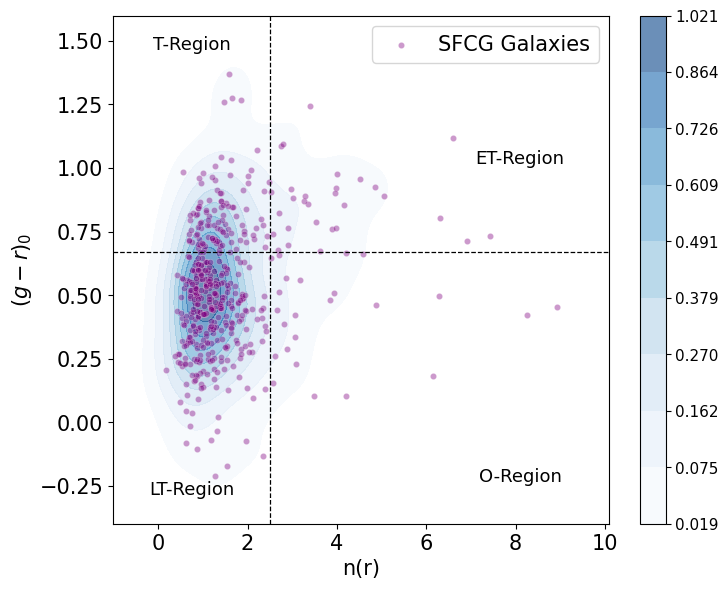

0.008316606305496783
473
0.5130374353805163


In [15]:
mask = [
    isinstance(value_g, (int, float)) and isinstance(value_r, (int, float))
    for value_g, value_r in zip(decals_k_corrected['m_g_corrected'], decals_k_corrected['m_r_corrected'])
]# Aplicamos la máscara para filtrar la tabla
decals_k_corrected = decals_k_corrected.to_pandas()
decals_no_zero = decals_k_corrected[mask]
decals_no_zero = decals_no_zero[decals_no_zero['n_r']!=0.0]
decals_no_zero = decals_no_zero[decals_no_zero['e_n_r'] < 2]
g_r_decals = decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']
n_r = decals_no_zero['n_r']

median_color = np.nanmedian(g_r_decals)
plt.figure(figsize=(8, 6.6))

kde = sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', alpha=0.6, fill=True, cbar=True)

sns.scatterplot(data=decals_no_zero, x=decals_no_zero['n_r'], y=g_r_decals, color='purple', alpha=0.4, s=20, label='SFCG Galaxies')

#plt.errorbar(decals_no_zero['n_r'], g_r_decals, xerr= decals_no_zero['e_n_r'], 
#             yerr=(decals_no_zero['e_mag_r']+decals_no_zero['e_mag_g']), fmt='None', 
#             color='darkviolet', lw=1, label='Error bars')

# Acceder al colorbar y cambiar el tamaño de los ticks
cbar = kde.figure.axes[-1]  # El colorbar es normalmente el último eje
cbar.tick_params(labelsize=11)

mean_error = np.mean(decals_no_zero['e_mag_r']+decals_no_zero['e_mag_g'])

plt.ylim(-0.4, 1.6)
#plt.xlim(0, )
plt.xticks(size=15)
plt.yticks(size=15)
#plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('$(g-r)_{0}$', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='upper right', fontsize=15)
plt.axhline(y=0.67, color='black', linestyle='--', linewidth=0.9)

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=0.9)

# Agregar texto en coordenadas específicas
plt.text(0.75, 1.45, 'T-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(0.75, -0.3, 'LT-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8.1, 1, 'ET-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8.1, -0.25, 'O-Region', fontsize=13, ha='center', va='bottom', color='black')

plt.show()
print(mean_error)
print(len(decals_no_zero))

valid = []
for dato in g_r_decals:
    if isinstance(dato, (int, float)):
        valid.append(dato)
print(np.median(valid))

In [16]:
late_type_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) <= 0.67) & (decals_no_zero['n_r'] <= 2.5)]
transition_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) > 0.67) & (decals_no_zero['n_r'] <= 2.5)]
early_type_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) >= 0.67) & (decals_no_zero['n_r'] > 2.5)]
other_sfcg = decals_no_zero[((decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']) < 0.67) & (decals_no_zero['n_r'] > 2.5)]

late_type_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) < 0.67) & (cs_no_zero['n_r'] <= 2.5)]
transition_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) > 0.67) & (cs_no_zero['n_r'] <= 2.5)]
early_type_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) > 0.67) & (cs_no_zero['n_r'] > 2.5)]
other_cs = cs_no_zero[((cs_no_zero['m_g_corrected'] - cs_no_zero['m_r_corrected']) < 0.67) & (cs_no_zero['n_r'] > 2.5)]

In [17]:
# Función para calcular el error mediante bootstrapping en la cantidad de galaxias por tipo
def bootstrap_count_error(data, total_samples, n_bootstrap=1000):
    boot_samples = np.random.choice(data, size=(n_bootstrap, len(data)), replace=True)
    boot_counts = [np.sum(sample) for sample in boot_samples]  # Contar galaxias en cada bootstrap
    return np.std(boot_counts)  # Desviación estándar como error

# Calcular el número de galaxias en cada tipo
N_total = len(cs_no_zero)
N_late = len(late_type_cs)
N_early = len(early_type_cs)
N_transition = len(transition_cs)
N_other = len(other_cs)

# Asegurarse de tener los identificadores de las galaxias para hacer las comparaciones
identificador = cs_no_zero['index']  # Suponiendo que 'id' es la columna de identificadores de galaxias

# Crear las máscaras booleanas usando np.isin
late_mask = np.isin(identificador, late_type_cs['index']).astype(int)
early_mask = np.isin(identificador, early_type_cs['index']).astype(int)
transition_mask = np.isin(identificador, transition_cs['index']).astype(int)
other_mask = np.isin(identificador, other_cs['index']).astype(int)

# Calcular los errores por tipo usando la función de bootstrap (como antes)
sigma_N_late = bootstrap_count_error(late_mask, N_total)
sigma_N_early = bootstrap_count_error(early_mask, N_total)
sigma_N_transition = bootstrap_count_error(transition_mask, N_total)
sigma_N_other = bootstrap_count_error(other_mask, N_total)

# Calcular los porcentajes
P_late = (N_late / N_total) * 100
P_early = (N_early / N_total) * 100
P_transition = (N_transition / N_total) * 100
P_other = (N_other / N_total) * 100

# Propagar los errores a los porcentajes
sigma_P_late = (sigma_N_late / N_total) * 100
sigma_P_early = (sigma_N_early / N_total) * 100
sigma_P_transition = (sigma_N_transition / N_total) * 100
sigma_P_other = (sigma_N_other / N_total) * 100

# Imprimir resultados con errores
print(f'La cantidad de galaxias Late-Type es: {N_late}, que corresponde a un {round(P_late, 2)}% ± {round(sigma_P_late, 2)}%')
print(f'La cantidad de galaxias Early-Type es: {N_early}, que corresponde a un {round(P_early, 2)}% ± {round(sigma_P_early, 2)}%')
print(f'La cantidad de galaxias en Transition es: {N_transition}, que corresponde a un {round(P_transition, 2)}% ± {round(sigma_P_transition, 2)}%')
print(f'La cantidad de galaxias en Other es: {N_other}, que corresponde a un {round(P_other, 2)}% ± {round(sigma_P_other, 2)}%')

La cantidad de galaxias Late-Type es: 453, que corresponde a un 60.81% ± 1.83%
La cantidad de galaxias Early-Type es: 79, que corresponde a un 10.6% ± 1.1%
La cantidad de galaxias en Transition es: 169, que corresponde a un 22.68% ± 1.53%
La cantidad de galaxias en Other es: 42, que corresponde a un 5.64% ± 0.86%


In [18]:
# Asegurarse de tener los identificadores de las galaxias para hacer las comparaciones
identificador = decals_no_zero['ID']  # Suponiendo que 'id' es la columna de identificadores de galaxias

# Calcular el número de galaxias en cada tipo
N_total = len(decals_no_zero)
N_late = len(late_type_sfcg)
N_early = len(early_type_sfcg)
N_transition = len(transition_sfcg)
N_other = len(other_sfcg)

# Crear las máscaras booleanas usando np.isin
late_mask = np.isin(identificador, late_type_sfcg['ID']).astype(int)
early_mask = np.isin(identificador, early_type_sfcg['ID']).astype(int)
transition_mask = np.isin(identificador, transition_sfcg['ID']).astype(int)
other_mask = np.isin(identificador, other_sfcg['ID']).astype(int)

# Calcular los errores por tipo usando la función de bootstrap (como antes)
sigma_N_late = bootstrap_count_error(late_mask, N_total)
sigma_N_early = bootstrap_count_error(early_mask, N_total)
sigma_N_transition = bootstrap_count_error(transition_mask, N_total)
sigma_N_other = bootstrap_count_error(other_mask, N_total)

# Calcular los porcentajes
P_late = (N_late / N_total) * 100
P_early = (N_early / N_total) * 100
P_transition = (N_transition / N_total) * 100
P_other = (N_other / N_total) * 100

# Propagar los errores a los porcentajes
sigma_P_late = (sigma_N_late / N_total) * 100
sigma_P_early = (sigma_N_early / N_total) * 100
sigma_P_transition = (sigma_N_transition / N_total) * 100
sigma_P_other = (sigma_N_other / N_total) * 100

# Imprimir resultados con errores
print(f'La cantidad de galaxias Late-Type es: {N_late}, que corresponde a un {round(P_late, 2)}% ± {round(sigma_P_late, 2)}%')
print(f'La cantidad de galaxias Early-Type es: {N_early}, que corresponde a un {round(P_early, 2)}% ± {round(sigma_P_early, 2)}%')
print(f'La cantidad de galaxias en Transition es: {N_transition}, que corresponde a un {round(P_transition, 2)}% ± {round(sigma_P_transition, 2)}%')
print(f'La cantidad de galaxias en Other es: {N_other}, que corresponde a un {round(P_other, 2)}% ± {round(sigma_P_other, 2)}%')

La cantidad de galaxias Late-Type es: 310, que corresponde a un 65.54% ± 2.14%
La cantidad de galaxias Early-Type es: 30, que corresponde a un 6.34% ± 1.17%
La cantidad de galaxias en Transition es: 109, que corresponde a un 23.04% ± 2.0%
La cantidad de galaxias en Other es: 24, que corresponde a un 5.07% ± 1.01%


In [19]:
sfr_decals = Table.read('sfr_decals_k_corrected.csv', format='ascii')
#print(len(sfr_decals_1))
#sfr_decals.rename_column('logSFR_NUV', 'log_SFR')
#sfr_decals.rename_column('log(M_stellar)', 'stellar_mass')
#sfr_decals.rename_column('stellar_mass', 'stellar_mass_phot')
sfr_decals.rename_column('zmemb', 'z')
sfr_decals = sfr_decals[sfr_decals['n_i'] != 0.0]
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_decals
sfr_decals['Distance (Mpc)'] = (sfr_decals['z']*c)/H_0
sfr_decals['M_i'] = sfr_decals['m_i_corrected'] - 5*np.log10(sfr_decals['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_decals['ebv']
sfr_decals['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_decals['m_g_corrected'] - sfr_decals['m_i_corrected']) - 0.4*sfr_decals['M_i'])


type_column = Column(['SFCG Galaxy'] * len(sfr_decals), name='Nature')
sfr_decals.add_column(type_column)
mask = ~np.isnan(sfr_decals['stellar_mass_phot_i'])

# Filtra la tabla usando la máscara
sfr_decals = sfr_decals[mask]
groups = sfr_decals.group_by('Group')
keys = groups.groups.keys
print(len(sfr_decals), len(keys))

378 110


In [20]:
sfr_cs = sfr_cs_blue
#sfr_cs.rename_column('logSFR_NUV', 'log_SFR')
#sfr_cs.rename_column('log(M_stellar)', 'stellar_mass')
#sfr_cs.rename_column('stellar_mass', 'stellar_mass_phot')
#sfr_cs.rename_column('zmemb', 'z')
sfr_cs = sfr_cs[sfr_cs['n_i'] != 0.0]
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_cs
sfr_cs['Distance (Mpc)'] = (sfr_cs['z']*c)/H_0
sfr_cs['M_i'] = sfr_cs['m_i_corrected'] - 5*np.log10(sfr_cs['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_cs['ebv']
sfr_cs['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_cs['m_g_corrected'] - sfr_cs['m_i_corrected']) - 0.4*sfr_cs['M_i'])


type_column = Column(['Field Galaxy'] * len(sfr_cs), name='Nature')
sfr_cs.add_column(type_column)
mask = ~np.isnan(sfr_cs['stellar_mass_phot_i'])

# Filtra la tabla usando la máscara
sfr_cs = sfr_cs[mask]

In [21]:
sfr_decals_plots = sfr_decals['Group', 'Gal', 'z', 'ra', 'dec', 'logSFR_NUV', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'm_g_corrected', 'm_r_corrected', 'm_i_corrected', 'm_z_corrected', 'e_n_r', 'e_RE_r']
control_sample_plots = sfr_cs['Group', 'Gal', 'z', 'ra', 'dec', 'logSFR_NUV', 'stellar_mass_phot_i', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature', 'm_g_corrected', 'm_r_corrected', 'm_i_corrected', 'm_z_corrected', 'e_n_r', 'e_RE_r']

cg_cs = vstack([sfr_decals_plots, control_sample_plots])

In [22]:
cg_cs = cg_cs[cg_cs['logSFR_NUV'] > -20]
cg_cs['log_sSFR'] = cg_cs['logSFR_NUV'] - cg_cs['stellar_mass_phot_i']
cg_cs['RE_g'] = cg_cs['RE_g']*0.262
cg_cs['RE_r'] = cg_cs['RE_r']*0.262
cg_cs['e_RE_r'] = cg_cs['e_RE_r']*0.262
cg_cs['RE_i'] = cg_cs['RE_i']*0.262
cg_cs['RE_z'] = cg_cs['RE_z']*0.262

cg_cs['Distance (Mpc)'] = 300000*cg_cs['z']/67.4
cg_cs['RE_g(kpc)'] = (cg_cs['RE_g']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_r(kpc)'] = (cg_cs['RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['e_RE_r(kpc)'] = (cg_cs['e_RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_i(kpc)'] = (cg_cs['RE_i']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_z(kpc)'] = (cg_cs['RE_z']*cg_cs['Distance (Mpc)'])/206.265

In [23]:
cg_cs = cg_cs[cg_cs['RE_g(kpc)'] < 100]
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'SFCG Galaxy']))
print(np.nanmedian(cg_cs['RE_g(kpc)'][cg_cs['Nature'] == 'Field Galaxy']))

4.535448526538238
4.416742959508529


/home/sortiz/miniconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [24]:
print(len(cg_cs), len(cg_cs[cg_cs['Nature'] == 'SFCG Galaxy']), len(cg_cs[cg_cs['Nature'] == 'Field Galaxy']))
cg_cs = cg_cs[(~np.isinf(cg_cs['stellar_mass_phot_i'])) & (~np.isnan(cg_cs['stellar_mass_phot_i'])) & (cg_cs['n_g'] != 0.0) & (~np.isinf(cg_cs['log_sSFR']))]
print(len(cg_cs), len(cg_cs[cg_cs['Nature'] == 'SFCG Galaxy']), len(cg_cs[cg_cs['Nature'] == 'Field Galaxy']))

1019 373 646
1019 373 646


In [25]:
# Definir ecuaciones de las líneas
def eq_starburst_line(mass):  # Línea punteada
    return 0.65 * (mass - 9) + 0.25

def eq_main_line(mass):  # Línea verde
    return 0.65 * (mass - 9) - 0.35

# Filtrar por tipo de galaxia
sfcg_mask = cg_cs['Nature'] == 'SFCG Galaxy'
field_mask = cg_cs['Nature'] == 'Field Galaxy'

# Contar galaxias en cada categoría
total_sfcg = sfcg_mask.sum()
total_field = field_mask.sum()

# Contar galaxias por encima de cada línea
above_starburst_sfcg = (cg_cs['logSFR_NUV'][sfcg_mask] > eq_starburst_line(cg_cs['stellar_mass_phot_i'][sfcg_mask])).sum() / total_sfcg
above_main_sfcg = (cg_cs['logSFR_NUV'][sfcg_mask] > eq_main_line(cg_cs['stellar_mass_phot_i'][sfcg_mask])).sum() / total_sfcg

above_starburst_cs = (cg_cs['logSFR_NUV'][field_mask] > eq_starburst_line(cg_cs['stellar_mass_phot_i'][field_mask])).sum() / total_field
above_main_cs = (cg_cs['logSFR_NUV'][field_mask] > eq_main_line(cg_cs['stellar_mass_phot_i'][field_mask])).sum() / total_field

# Resultados
print(f"Galaxias sobre la línea starburst en SFCGs: {above_starburst_sfcg * 100:.2f}%")
print(f"Galaxias sobre la línea main en SFCGs: {above_main_sfcg * 100:.2f}%")

print(f"Galaxias sobre la línea starburst en CS: {above_starburst_cs * 100:.2f}%")
print(f"Galaxias sobre la línea main en CS: {above_main_cs * 100:.2f}%")

Galaxias sobre la línea starburst en SFCGs: 38.34%
Galaxias sobre la línea main en SFCGs: 84.72%
Galaxias sobre la línea starburst en CS: 14.71%
Galaxias sobre la línea main en CS: 59.44%


<>:55: SyntaxWarning: invalid escape sequence '\o'
<>:55: SyntaxWarning: invalid escape sequence '\o'
<>:55: SyntaxWarning: invalid escape sequence '\o'
<>:55: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_8571/3441522161.py:55: SyntaxWarning: invalid escape sequence '\o'
  g.set_axis_labels("log $M_{*} [M_{\odot}]$", "log $SFR [M_{\odot}/yr]$", fontsize=17)
/tmp/ipykernel_8571/3441522161.py:55: SyntaxWarning: invalid escape sequence '\o'
  g.set_axis_labels("log $M_{*} [M_{\odot}]$", "log $SFR [M_{\odot}/yr]$", fontsize=17)
/home/sortiz/miniconda3/lib/python3.13/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


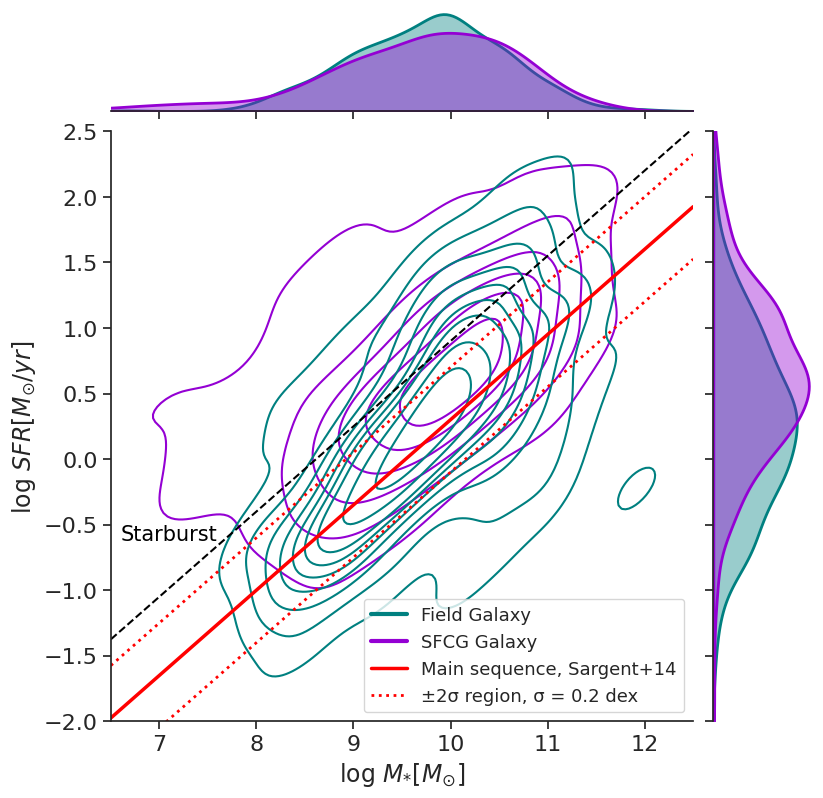

In [26]:
from matplotlib.lines import Line2D

cg_cs = cg_cs.to_pandas()

# Definir paleta personalizada
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}

sns.set_theme(style="ticks")
# Definir la dispersión sigma
sigma = 0.2  # Ajustar si tienes una referencia específica

# Función para la ecuación de la línea de la secuencia principal
def eq_main_line(mass):
    return 0.65 * (mass - 9) - 0.35

# Definir variables
y = cg_cs['logSFR_NUV']
x = cg_cs['stellar_mass_phot_i']
sur = cg_cs['Nature']

# Crear la figura
g = sns.JointGrid(data=cg_cs, x=x, y=y, hue=sur, palette=custom_palette, height=8)

# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(sns.kdeplot, fill=False, alpha=1, linewidth=0)

# Gráficos marginales: KDE relleno
g.plot_marginals(sns.kdeplot, fill=True, common_norm=False, alpha=0.4, linewidth=2)

# Añadir la recta discontinua de Starburst
g.ax_joint.axline((9, 0.25), slope=0.65, color='black', linestyle='--')

# Añadir la línea principal (secuencia principal)
line_green = g.ax_joint.axline((9, -0.35), slope=0.65, color='red', linestyle='-', linewidth=2.5)
line_green.set_label('Main sequence, Sargent+14')

# Generar valores de masa estelar para las líneas de 2σ
mass_range = np.linspace(6.5, 12.5, 100)
main_line_values = eq_main_line(mass_range)
upper_bound = main_line_values + 2 * sigma
lower_bound = main_line_values - 2 * sigma

# Graficar las líneas de ±2σ
g.ax_joint.plot(mass_range, upper_bound, color='red', linestyle='dotted', linewidth=2)
g.ax_joint.plot(mass_range, lower_bound, color='red', linestyle='dotted', linewidth=2)

# Limitar los ejes
g.ax_joint.set_xlim(6.5, 12.5)
g.ax_joint.set_ylim(-2, 2.5)

# Añadir texto descriptivo
g.ax_joint.text(6.6, -0.65, 'Starburst', color='black', fontsize=15, verticalalignment='bottom')

# Configurar etiquetas de ejes y ticks
g.set_axis_labels("log $M_{*} [M_{\odot}]$", "log $SFR [M_{\odot}/yr]$", fontsize=17)
g.ax_joint.tick_params(axis='both', labelsize=16)

# Crear handles y labels para la leyenda
handles = [
    Line2D([0], [0], color='teal', lw=3, label='Field Galaxy'),
    Line2D([0], [0], color='darkviolet', lw=3, label='SFCG Galaxy'),
    Line2D([0], [0], color='red', linestyle='-', linewidth=2.5, label='Main sequence, Sargent+14'),
    Line2D([0], [0], color='red', linestyle='dotted', linewidth=2, label='±2σ region, σ = 0.2 dex')
]

# Añadir la leyenda
g.ax_joint.legend(handles=handles, loc="lower right", fontsize=13)

# Mostrar el gráfico
plt.show()

In [27]:
# Determinar los límites de ±2σ alrededor de la línea main sequence
def eq_main_line(mass):
    return 0.65 * (mass - 9) - 0.35

lower_bound = eq_main_line(cg_cs['stellar_mass_phot_i']) - 2 * sigma
upper_bound = eq_main_line(cg_cs['stellar_mass_phot_i']) + 2 * sigma

# Filtrar galaxias Field dentro de 2σ
within_2sigma_field = ((cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'Field Galaxy'] >= lower_bound[cg_cs['Nature'] == 'Field Galaxy']) &
                        (cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'Field Galaxy'] <= upper_bound[cg_cs['Nature'] == 'Field Galaxy'])).sum()

# Filtrar galaxias Field dentro de 2σ
within_2sigma_sfcg = ((cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'SFCG Galaxy'] >= lower_bound[cg_cs['Nature'] == 'SFCG Galaxy']) &
                        (cg_cs['logSFR_NUV'][cg_cs['Nature'] == 'SFCG Galaxy'] <= upper_bound[cg_cs['Nature'] == 'SFCG Galaxy'])).sum()

# Calcular porcentaje
total_field = (cg_cs['Nature'] == 'Field Galaxy').sum()
percentage_within_2sigma = (within_2sigma_field / total_field) * 100

# Calcular porcentaje
total_sfcg = (cg_cs['Nature'] == 'SFCG Galaxy').sum()
percentage_within_2sigma_sfcg = (within_2sigma_sfcg / total_sfcg) * 100

# Mostrar resultado
print(f"Porcentaje de galaxias Field dentro de ±2σ de la Main Sequence: {percentage_within_2sigma:.2f}%")
print(f"Porcentaje de galaxias SFCG dentro de ±2σ de la Main Sequence: {percentage_within_2sigma_sfcg:.2f}%")

Porcentaje de galaxias Field dentro de ±2σ de la Main Sequence: 62.85%
Porcentaje de galaxias SFCG dentro de ±2σ de la Main Sequence: 43.70%


In [28]:
late_type = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) < 0.67) & (cg_cs['n_r'] <= 2.5)]
transition = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) > 0.67) & (cg_cs['n_r'] <= 2.5)]
early_type = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) > 0.67) & (cg_cs['n_r'] > 2.5)]
other = cg_cs[((cg_cs['m_g_corrected'] - cg_cs['m_r_corrected']) < 0.67) & (cg_cs['n_r'] > 2.5)]
print(len(late_type), len(transition), len(early_type), len(other))
transition = transition[(transition['n_r'] != 0.0) & (transition['RE_r(kpc)'] != 0.0)]

640 231 89 53


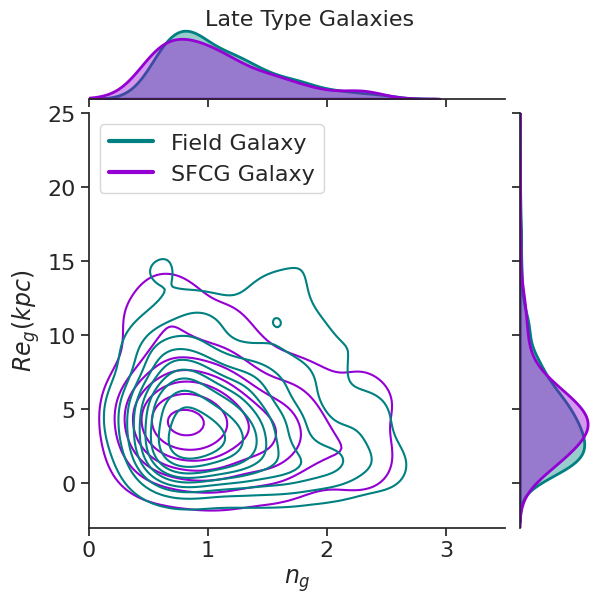

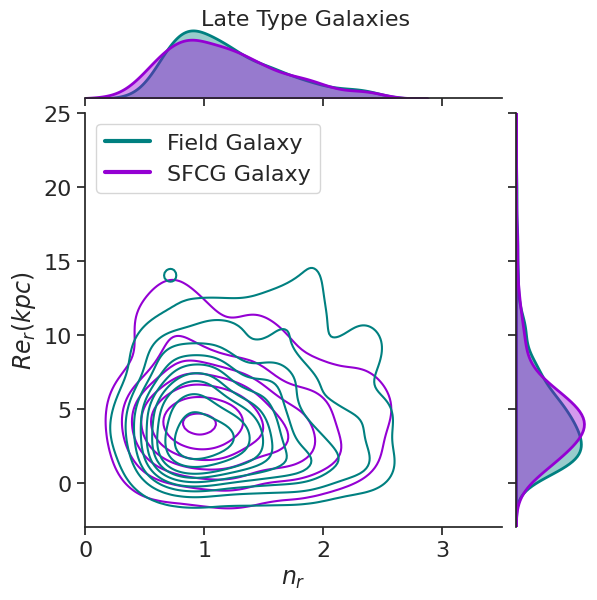

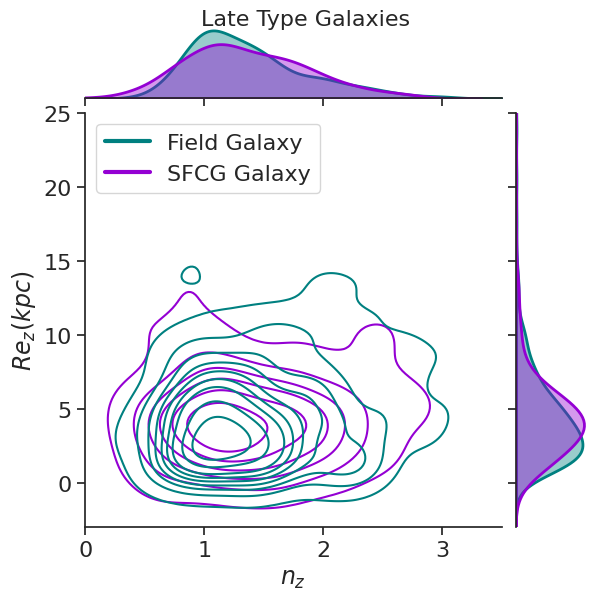

In [30]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = late_type['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']
filtro = ['g', 'r', 'z']
# Crear el gráfico
for col_x, col_y, f in zip(x_columns, y_columns, filtro):    
    # Crear la figura
    g = sns.JointGrid(data=late_type, x=late_type[col_x], y=late_type[col_y], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 3.5)
    g.ax_joint.set_ylim(-3, 25)
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left", fontsize=16)
    # Añadir títulos
    g.set_axis_labels(f"$n_{f}$", f"$Re_{f} (kpc)$", fontsize=17)
    g.fig.suptitle(f"Late Type Galaxies", fontsize=16)  # Título principal
    g.ax_joint.tick_params(labelsize=16)
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga
    # Mostrar el gráfico
    plt.show()

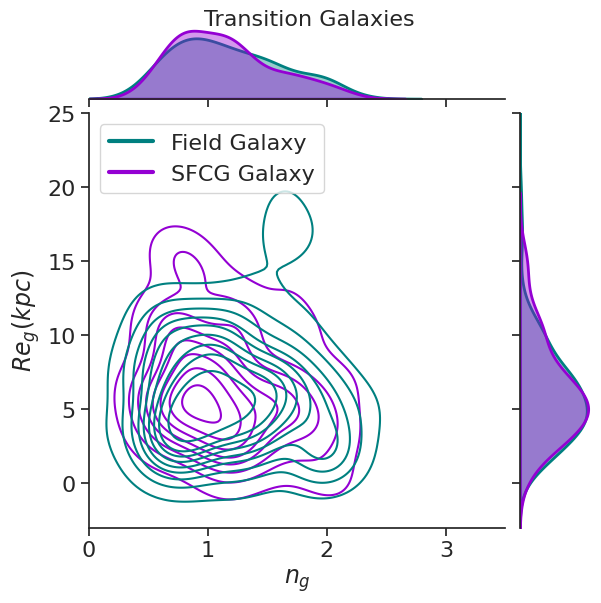

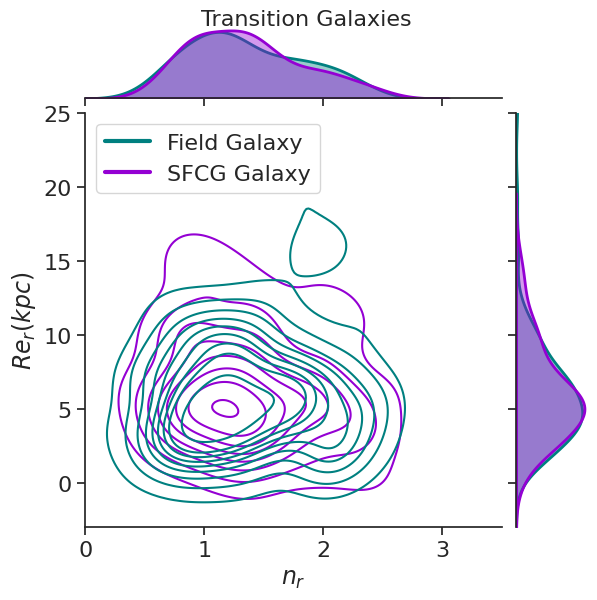

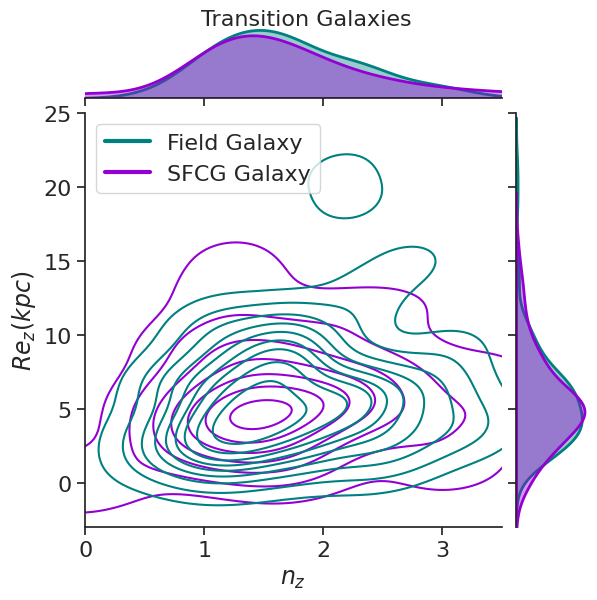

In [31]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'teal', 'SFCG Galaxy': 'darkviolet'}


sur = transition['Nature']

# Lista de columnas que quieres graficar
x_columns = ['n_g', 'n_r', 'n_z']
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']
filtro = ['g', 'r', 'z']
# Crear el gráfico
for col_x, col_y, f in zip(x_columns, y_columns, filtro):    
    # Crear la figura
    g = sns.JointGrid(data=transition, x=transition[col_x], y=transition[col_y], hue=sur, palette=custom_palette)
    
    # Gráficos principales: KDE con efecto desvanecido
    g.plot_joint(
        sns.kdeplot,
        fill=False,
        alpha=1,
        linewidth=0,  # Contornos suaves
    )
    
    # Gráficos marginales: KDE relleno
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        common_norm=False,
        alpha=0.4,  # Transparencia
        linewidth=2  # Sin bordes
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(0, 3.5)
    g.ax_joint.set_ylim(-3, 25)
    # Crear handles y labels para la leyenda
    handles = [
    Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette
    ]
    labels = list(custom_palette.keys())

    # Añadir la leyenda
    g.ax_joint.legend(handles=handles, labels=labels, loc="upper left", fontsize=16)
    # Añadir títulos
    g.set_axis_labels(f"$n_{f}$", f"$Re_{f} (kpc)$", fontsize=17)
    g.fig.suptitle(f"Transition Galaxies", fontsize=16)  # Título principal
    g.ax_joint.tick_params(labelsize=16)

    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga
    # Mostrar el gráfico
    plt.show()

In [ ]:
# Diccionario con los tipos de galaxias
galaxy_types = {'Transition Galaxies': transition, 'Late Type': late_type}

# Colores para los dos tipos de galaxias
color_map = {'SFCG Galaxy': 'darkviolet', 'Field Galaxy': 'teal'}
filtros = ['g', 'r', 'z']
# Figuras y ejes
fig, axs = plt.subplots(4, 6, figsize=(25, 17), gridspec_kw={'width_ratios': [6, 2, 6, 2, 6, 2], 'height_ratios': [2, 6, 2, 6]})

for i, (name, data) in enumerate(galaxy_types.items()):
    bin_edges = np.linspace(min(data['stellar_mass_phot_i'].min(), data['stellar_mass_phot_i'].min()), 
                        max(data['stellar_mass_phot_i'].max(), data['stellar_mass_phot_i'].max()), 
                        21)
    bin_edges_re = np.linspace(min(data['RE_g(kpc)'].min(), data['RE_g(kpc)'].min()), 
                        max(data['RE_g(kpc)'].max(), data['RE_g(kpc)'].max()), 
                        21)
    for j, re_col in enumerate(['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']):
        ax = axs[2*i-1, 2*j]
        ax_histx = axs[2*i-2, 2*j] #Panel del histograma en x
        ax_histy = axs[2*i-1, 2*j+1] #Panel del histograma en y
        

        ax.set_title(f'{name}', size=23)
        # Dividir los datos por Nature
        for nature_type, color in color_map.items():
            subset = data[data['Nature'] == nature_type]
            
            #Graficando KDE
            kde_plot = sns.kdeplot(x=subset['stellar_mass_phot_i'], y=subset[re_col], ax=ax, fill=False, color=color, alpha = 0.9, label=nature_type)
            
            # Calcular medianas
            median_x = np.median(subset['stellar_mass_phot_i'])
            median_y = np.median(subset[re_col])
            
            #Histogramas
            ax_histx.hist(subset['stellar_mass_phot_i'], bins=bin_edges, color=color, alpha=0.3, density=True, edgecolor='black')
            ax_histy.hist(subset[re_col], bins=bin_edges_re, color=color, alpha=0.3, orientation='horizontal', density=True, edgecolor='black')
        
            # Añadir líneas de la mediana
            ax_histx.axvline(median_x, color=color, linestyle='--', linewidth=4)
            ax_histy.axhline(median_y, color=color, linestyle='--', linewidth=4)
        
        # Personalización de ejes
        ax_histx.set_xlim(6, 12)
        ax_histy.set_ylim(-2, 30)
        ax_histx.tick_params(axis='x', labelsize=16)
        ax_histx.tick_params(axis='y', labelsize=16)
        ax_histy.tick_params(axis='x', labelsize=16)
        ax_histy.tick_params(axis='y', labelsize=16)
        
        ax_histy.yaxis.set_label_position("left")
        ax_histy.yaxis.tick_right()
        # Etiquetas personalizadas de los ejes
        ax.set_xlabel(f'log($M_*(M_\odot)$)', size=20)
        ax.set_ylabel(f'$Re_{filtros[j]}$', size=20)
        ax.set_xlim(6, 12)
        ax.set_ylim(-3, 30)
        # Cambiar el tamaño de las etiquetas de los ticks
        ax.tick_params(axis='x', labelsize=17)
        ax.tick_params(axis='y', labelsize=17)
        handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles, labels, title='Galaxy Type', loc='upper left')
# Eliminar los ejes innecesarios (las filas 1, 3 y 5, columnas 2, 4 y 6)
for i in [0, 2]:
    for j in [1, 3, 5]:
        axs[i, j].set_visible(False)
# Configuración global
plt.tight_layout()
#plt.subplots_adjust(wspace=0.2)  # Reducir espacios entre subplots



In [32]:
median_re_late_sfcg = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_re_late_sfcg = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'SFCG Galaxy'])
median_re_transition_sfcg = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_error_re_transition_sfcg = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'SFCG Galaxy'])
median_re_early_sfcg = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_re_early_sfcg = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'SFCG Galaxy'])

median_re_late_cs = np.nanmedian(late_type['RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_error_re_late_cs = np.nanmedian(late_type['e_RE_r(kpc)'][late_type['Nature'] == 'Field Galaxy'])
median_re_transition_cs = np.nanmedian(transition['RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_error_re_transition_cs = np.nanmedian(transition['e_RE_r(kpc)'][transition['Nature'] == 'Field Galaxy'])
median_re_early_cs = np.nanmedian(early_type['RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])
median_error_re_early_cs = np.nanmedian(early_type['e_RE_r(kpc)'][early_type['Nature'] == 'Field Galaxy'])
median_re_other_cs = np.nanmedian(other['RE_r(kpc)'][other['Nature'] == 'Field Galaxy'])
median_error_re_other_cs = np.nanmedian(other['e_RE_r(kpc)'][other['Nature'] == 'Field Galaxy'])
median_re_cs = np.nanmedian(cg_cs['RE_r(kpc)'][cg_cs['Nature'] == 'Field Galaxy'])
median_error_re_cs = np.nanmedian(cg_cs['e_RE_r(kpc)'][cg_cs['Nature'] == 'Field Galaxy'])

median_n_late_sfcg = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_error_n_late_sfcg = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'SFCG Galaxy'])
median_n_transition_sfcg = np.nanmedian(transition['n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_error_n_transition_sfcg = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'SFCG Galaxy'])
median_n_early_sfcg = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'SFCG Galaxy'])
median_error_n_early_sfcg = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'SFCG Galaxy'])

median_n_late_cs = np.nanmedian(late_type['n_r'][late_type['Nature'] == 'Field Galaxy'])
median_error_n_late_cs = np.nanmedian(late_type['e_n_r'][late_type['Nature'] == 'Field Galaxy'])
median_n_transition_cs = np.nanmedian(transition['n_r'][transition['Nature'] == 'Field Galaxy'])
median_error_n_transition_cs = np.nanmedian(transition['e_n_r'][transition['Nature'] == 'Field Galaxy'])
median_n_early_cs = np.nanmedian(early_type['n_r'][early_type['Nature'] == 'Field Galaxy'])
median_error_n_early_cs = np.nanmedian(early_type['e_n_r'][early_type['Nature'] == 'Field Galaxy'])
median_n_other_cs = np.nanmedian(other['n_r'][other['Nature'] == 'Field Galaxy'])
median_error_n_other_cs = np.nanmedian(other['e_n_r'][other['Nature'] == 'Field Galaxy'])
median_n_cs = np.nanmedian(cg_cs['n_r'][cg_cs['Nature'] == 'Field Galaxy'])
median_error_n_cs = np.nanmedian(cg_cs['e_n_r'][cg_cs['Nature'] == 'Field Galaxy'])

print(f'Median effective radius for late type SFCG galaxies: {median_re_late_sfcg} \u00B1 {median_error_re_late_sfcg}')
print(f'Median effective radius for late type Field galaxies: {median_re_late_cs} \u00B1 {median_error_re_late_cs}')

print(f'Median effective radius for transition SFCG galaxies: {median_re_transition_sfcg} \u00B1 {median_error_re_transition_sfcg}')
print(f'Median effective radius for transition Field galaxies: {median_re_transition_cs} \u00B1 {median_error_re_transition_cs}')

print(f'Median effective radius for early type SFCG galaxies: {median_re_early_sfcg} \u00B1 {median_error_re_early_sfcg}')
print(f'Median effective radius for early type Field galaxies: {median_re_early_cs} \u00B1 {median_error_re_early_cs}')

print(f'Median effective radius for other type Field galaxies: {median_re_other_cs} \u00B1 {median_error_re_other_cs}')
print(f'Median effective radius for Field galaxies: {median_re_cs} \u00B1 {median_error_re_cs}')



print(f'Median Sérsic Index for late type SFCG galaxies: {median_n_late_sfcg} \u00B1 {median_error_n_late_sfcg}')
print(f'Median Sérsic Index for late type Field galaxies: {median_n_late_cs} \u00B1 {median_error_n_late_cs}')

print(f'Median Sérsic Index for transition SFCG galaxies: {median_n_transition_sfcg} \u00B1 {median_error_n_transition_sfcg}')
print(f'Median Sérsic Index for transition Field galaxies: {median_n_transition_cs} \u00B1 {median_error_n_transition_cs}')

print(f'Median Sérsic Index for early type SFCG galaxies: {median_n_early_sfcg} \u00B1 {median_error_n_early_sfcg}')
print(f'Median Sérsic Index for early type Field galaxies: {median_n_early_cs} \u00B1 {median_error_n_early_cs}')

print(f'Median Sérsic Index for other type Field galaxies: {median_n_other_cs} \u00B1 {median_error_n_other_cs}')

print(f'Median Sérsic Index for Field galaxies: {median_n_cs} \u00B1 {median_error_n_cs}')



Median effective radius for late type SFCG galaxies: 4.176897572272597 ± 0.00464419921335098
Median effective radius for late type Field galaxies: 3.862740593346651 ± 0.0037226595012135075
Median effective radius for transition SFCG galaxies: 5.369450110824419 ± 0.003716553444076471
Median effective radius for transition Field galaxies: 5.176956373499246 ± 0.005649685903609491
Median effective radius for early type SFCG galaxies: 7.668952500399755 ± 0.012794367529137885
Median effective radius for early type Field galaxies: 5.099080512299403 ± 0.013078806893353535
Median effective radius for other type Field galaxies: 2.996504797600908 ± 0.007516104035163777
Median effective radius for Field galaxies: 4.290573416079587 ± 0.00488278208846748
Median Sérsic Index for late type SFCG galaxies: 1.0974 ± 0.0023
Median Sérsic Index for late type Field galaxies: 1.1074 ± 0.0018
Median Sérsic Index for transition SFCG galaxies: 1.3097 ± 0.0013
Median Sérsic Index for transition Field galaxies: 1

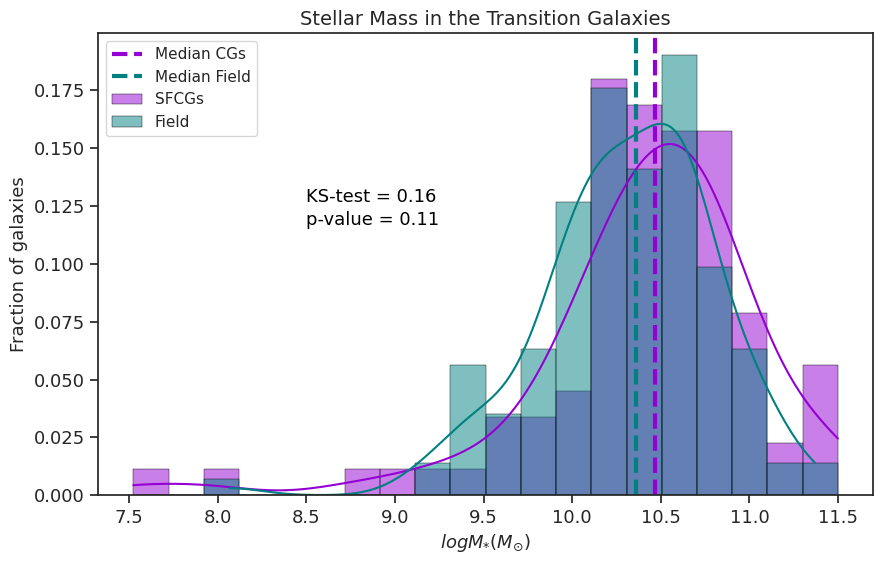

0.15936065833201457 0.10864746934136404


In [33]:
mass_transition_sfcg = transition['stellar_mass_phot_i'][transition['Nature'] == 'SFCG Galaxy']
mass_transition_cs = transition['stellar_mass_phot_i'][transition['Nature'] == 'Field Galaxy']

bin_edges = np.linspace(min(mass_transition_sfcg.min(), mass_transition_cs.min()), 
                        max(mass_transition_sfcg.max(), mass_transition_cs.max()), 
                        21)

# Crear los histogramas con los mismos bordes de bins
plt.figure(figsize=(10, 6))
sns.histplot(mass_transition_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(mass_transition_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Calcular medianas
median_x = np.median(mass_transition_sfcg)
median_x_2 = np.median(mass_transition_cs)

# Añadir líneas de la mediana 
plt.axvline(median_x, color='darkviolet', linestyle='--', linewidth=3, label='Median CGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=3, label='Median Field')
# Añadir texto al gráfico
plt.text(8.5, 0.125, 'KS-test = 0.16', color='black', fontsize=13, verticalalignment='bottom')
plt.text(8.5, 0.115, 'p-value = 0.11', color='black', fontsize=13, verticalalignment='bottom')

# Etiquetas y título
plt.xlabel('$log M_{*}(M_{\odot})$', size=13)
plt.ylabel('Fraction of galaxies', size=13)
plt.title('Stellar Mass in the Transition Galaxies', size=14)
plt.xticks(size=13)
plt.yticks(size=13)

plt.legend()

plt.show()

# Realizar el KS test
ks_stat, p_value = ks_2samp(mass_transition_sfcg, mass_transition_cs)
print(ks_stat, p_value)

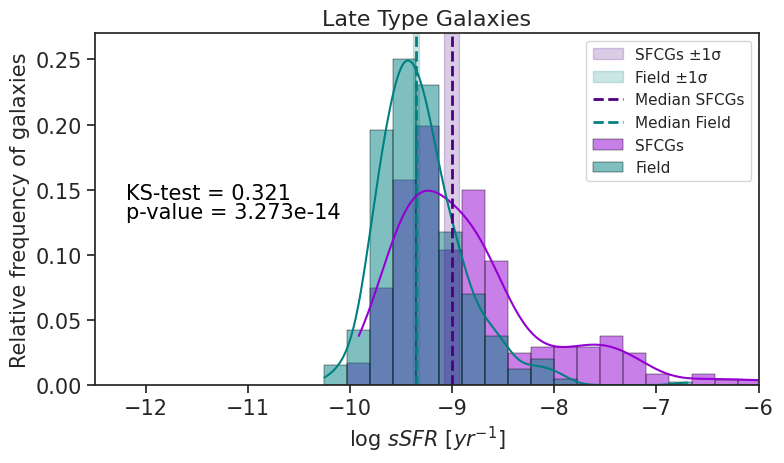

0.3209267983236099 3.272663730933249e-14


In [43]:
# Subconjuntos
ssfr_late_sfcg = late_type['log_sSFR'][late_type['Nature'] == 'SFCG Galaxy']
ssfr_late_cs = late_type['log_sSFR'][late_type['Nature'] == 'Field Galaxy']

# Función bootstrap para la mediana
def bootstrap_median_ci(data, n_bootstrap=1000, ci=68):
    medians = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        medians.append(np.median(sample))
    lower = np.percentile(medians, 50 - ci/2)
    upper = np.percentile(medians, 50 + ci/2)
    return lower, upper

# Calcular bordes
bin_edges = np.linspace(min(ssfr_late_sfcg.min(), ssfr_late_cs.min()), 
                        max(ssfr_late_sfcg.max(), ssfr_late_cs.max()), 
                        21)

# Calcular medianas y ±1σ
median_sfcg = np.median(ssfr_late_sfcg)
low_sfcg, high_sfcg = bootstrap_median_ci(ssfr_late_sfcg)

median_cs = np.median(ssfr_late_cs)
low_cs, high_cs = bootstrap_median_ci(ssfr_late_cs)

# Graficar
plt.figure(figsize=(8, 4.8))
sns.histplot(ssfr_late_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Regiones sombreadas ±1σ
plt.axvspan(low_sfcg, high_sfcg, color='indigo', alpha=0.2, label='SFCGs ±1σ')
plt.axvspan(low_cs, high_cs, color='teal', alpha=0.2, label='Field ±1σ')

# Líneas de mediana
plt.axvline(median_sfcg, color='indigo', linestyle='--', linewidth=2, label='Median SFCGs')
plt.axvline(median_cs, color='teal', linestyle='--', linewidth=2, label='Median Field')

# Texto del KS test
plt.text(-12.2, 0.14, 'KS-test = 0.321', color='black', fontsize=15, verticalalignment='bottom')
plt.text(-12.2, 0.125, 'p-value = 3.273e-14', color='black', fontsize=15, verticalalignment='bottom')

# Etiquetas
plt.xlabel('log $sSFR\ [yr^{-1}]$', size=15)
plt.ylabel('Relative frequency of galaxies', size=15)
plt.title('Late Type Galaxies', size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-12.5, -6)
plt.ylim(0, 0.27)
plt.legend()
plt.tight_layout()
plt.show()

# KS test
ks_stat, p_value = ks_2samp(ssfr_late_sfcg, ssfr_late_cs)
print(ks_stat, p_value)

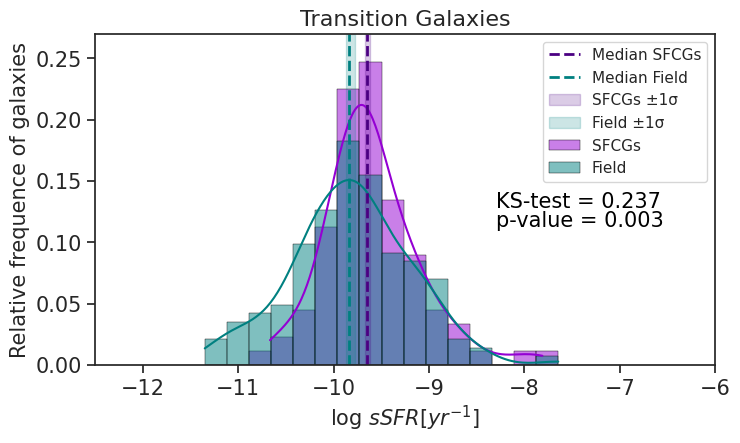

0.23690457350846653 0.0033931596280276765


In [51]:
# Subconjuntos
ssfr_late_sfcg = transition['log_sSFR'][transition['Nature'] == 'SFCG Galaxy']
ssfr_late_cs = transition['log_sSFR'][transition['Nature'] == 'Field Galaxy']

# Bordes de bins
bin_edges = np.linspace(min(ssfr_late_sfcg.min(), ssfr_late_cs.min()), 
                        max(ssfr_late_sfcg.max(), ssfr_late_cs.max()), 
                        17)

# Figura
plt.figure(figsize=(8, 4.3))
sns.histplot(ssfr_late_sfcg, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='darkviolet', label='SFCGs', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, color='teal', label='Field', edgecolor='black', linewidth=0.3)

# Medianas y bootstrapping
median_x = np.median(ssfr_late_sfcg)
median_x_2 = np.median(ssfr_late_cs)

ci_sfcg = bootstrap_median_ci(ssfr_late_sfcg)
ci_field = bootstrap_median_ci(ssfr_late_cs)

# Líneas de mediana
plt.axvline(median_x, color='indigo', linestyle='--', linewidth=2, label='Median SFCGs')
plt.axvline(median_x_2, color='teal', linestyle='--', linewidth=2, label='Median Field')

# Regiones sombreadas de incertidumbre
plt.axvspan(ci_sfcg[0], ci_sfcg[1], color='indigo', alpha=0.2, label='SFCGs ±1σ')
plt.axvspan(ci_field[0], ci_field[1], color='teal', alpha=0.2, label='Field ±1σ')

# Texto KS
plt.text(-8.3, 0.125, 'KS-test = 0.237', color='black', fontsize=15, verticalalignment='bottom')
plt.text(-8.3, 0.11, 'p-value = 0.003', color='black', fontsize=15, verticalalignment='bottom')

# Estética
plt.xlabel('log $sSFR [yr^{-1}]$', size=15)
plt.ylabel('Relative frequence of galaxies', size=15)
plt.title('Transition Galaxies', size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-12.5, -6)
plt.ylim(0, 0.27)
plt.legend()
plt.show()

# KS test
ks_stat, p_value = ks_2samp(ssfr_late_sfcg, ssfr_late_cs)
print(ks_stat, p_value)


In [ ]:
def bootstrap_mediana(valores, num_bootstrap=1000):
    """
    Calcula la mediana y el error de la mediana usando bootstrap.
    
    :param valores: array-like, valores sobre los que se calcula la mediana.
    :param num_bootstrap: int, número de muestras bootstrap.
    :return: mediana_bootstrap, error_bootstrap
    """
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0.0)]
    if len(valores_filtrados) == 0:
        print("NO HAY VALORES QUE CALCULAR")
        return np.nan, np.nan
    
    # Crear muestras bootstrap
    medianas_bootstrap = []
    for _ in range(num_bootstrap):
        muestra = np.random.choice(valores_filtrados, size=len(valores_filtrados), replace=True)
        medianas_bootstrap.append(np.nanmedian(muestra))
    
    # Calcular estadística final
    mediana_bootstrap = np.nanmedian(medianas_bootstrap)
    error_bootstrap = np.std(medianas_bootstrap)  # Puede usarse también el percentil para intervalos de confianza
    return mediana_bootstrap, error_bootstrap

In [ ]:
tabla_names = ['Early Type', 'Late Type', 'Transition', 'Other', 'All']

tablas = [early_type, late_type, transition, other, cg_cs]

for tabla, name in zip(tablas, tabla_names):
    tabla_sfcg = tabla[tabla['Nature'] == 'SFCG Galaxy']
    tabla_cs = tabla[tabla['Nature'] == 'Field Galaxy']
    
    sfr_sfcg = tabla_sfcg['logSFR_NUV']
    sfr_cs = tabla_cs['logSFR_NUV']
    
    ssfr_sfcg = tabla_sfcg['log_sSFR']
    ssfr_cs = tabla_cs['log_sSFR']
    
    mass_sfcg = tabla_sfcg['stellar_mass_phot_i']
    mass_cs = tabla_cs['stellar_mass_phot_i']
    
    median_sfr_sfcg, error_sfr_sfcg = bootstrap_mediana(sfr_sfcg)
    median_sfr_cs, error_sfr_cs = bootstrap_mediana(sfr_cs)
    
    median_ssfr_sfcg, error_ssfr_sfcg = bootstrap_mediana(ssfr_sfcg)
    median_ssfr_cs, error_ssfr_cs = bootstrap_mediana(ssfr_cs)

    median_mass_sfcg, error_mass_sfcg = bootstrap_mediana(mass_sfcg)
    median_mass_cs, error_mass_cs = bootstrap_mediana(mass_cs)

    print(f'Median SFR in SFCGs for {name}: {median_sfr_sfcg:.2f} ± {error_sfr_sfcg:.2f}')
    print(f'Median SFR in CS for {name}: {median_sfr_cs:.2f} ± {error_sfr_cs:.2f}')

    print(f'Median sSFR in SFCGs for {name}: {median_ssfr_sfcg:.2f} ± {error_ssfr_sfcg:.2f}')
    print(f'Median sSFR in CS for {name}: {median_ssfr_cs:.2f} ± {error_ssfr_cs:.2f}')

    print(f'Median Mass in SFCGs for {name}: {median_mass_sfcg:.2f} ± {error_mass_sfcg:.2f}')
    print(f'Median Mass in CS for {name}: {median_mass_cs:.2f} ± {error_mass_cs:.2f}')